# 변동성 돌파 + 상대모멘텀 포트폴리오 전략

기존 변동성 돌파 전략에 상대모멘텀을 적용하여 포트폴리오 수익률 극대화
- 상대모멘텀: 최근 수익률이 높은 종목에 더 많은 비중 배분
- 동적 리밸런싱: 주기적으로 종목별 비중 재조정

## 1. 필요한 라이브러리 임포트 및 환경 설정

In [44]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# matplotlib 한글 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

## 2. BigQuery 연결 및 ADX 포함 데이터 로드 함수

In [45]:
# BigQuery 클라이언트 초기화
def get_bigquery_client():
    service_account_path = "/Users/cg01-piwoo/my_quant/access_info/data/quantsungyong-663604552de9.json"
    credentials = service_account.Credentials.from_service_account_file(
        service_account_path,
        scopes=["https://www.googleapis.com/auth/cloud-platform"]
    )
    return bigquery.Client(credentials=credentials, project=credentials.project_id)

client = get_bigquery_client()

# ADX 지표를 포함한 데이터 로드 함수
def get_stock_data_with_adx(ticker, start_date=None, end_date=None):
    date_conditions = []
    if start_date:
        date_conditions.append(f"JSON_EXTRACT_SCALAR(r.dates_array[OFFSET(i.pos)], '$') >= '{start_date}'")
    if end_date:
        date_conditions.append(f"JSON_EXTRACT_SCALAR(r.dates_array[OFFSET(i.pos)], '$') <= '{end_date}'")
    
    date_filter = f"AND {' AND '.join(date_conditions)}" if date_conditions else ""
    
    query = f"""
    WITH raw_data AS (
      SELECT 
        ticker,
        -- 가격 데이터
        JSON_EXTRACT_ARRAY(data, '$.dates') AS dates_array,
        JSON_EXTRACT_ARRAY(data, '$.open') AS open_array,
        JSON_EXTRACT_ARRAY(data, '$.high') AS high_array,
        JSON_EXTRACT_ARRAY(data, '$.low') AS low_array,
        JSON_EXTRACT_ARRAY(data, '$.close') AS close_array,
        JSON_EXTRACT_ARRAY(data, '$.volume') AS volume_array,
        
        -- ADX 관련 지표
        JSON_EXTRACT_ARRAY(data, '$.adx_14_values') AS adx_14_values_array,
        JSON_EXTRACT_ARRAY(data, '$.pdi_14_values') AS pdi_14_values_array,
        JSON_EXTRACT_ARRAY(data, '$.mdi_14_values') AS mdi_14_values_array,
        
        -- 배열 길이
        ARRAY_LENGTH(JSON_EXTRACT_ARRAY(data, '$.close')) AS array_length
        
      FROM 
        `quantsungyong.finviz_data.stock_data_with_indicators`
      WHERE 
        ticker = '{ticker}'
    ),
    indices AS (
      SELECT r.ticker, pos
      FROM raw_data r,
      UNNEST(GENERATE_ARRAY(0, r.array_length - 1)) AS pos
    )
    SELECT 
      -- 날짜와 가격 데이터
      JSON_EXTRACT_SCALAR(r.dates_array[OFFSET(i.pos)], '$') AS date,
      CAST(JSON_EXTRACT_SCALAR(r.open_array[OFFSET(i.pos)], '$') AS FLOAT64) AS open,
      CAST(JSON_EXTRACT_SCALAR(r.high_array[OFFSET(i.pos)], '$') AS FLOAT64) AS high,
      CAST(JSON_EXTRACT_SCALAR(r.low_array[OFFSET(i.pos)], '$') AS FLOAT64) AS low,
      CAST(JSON_EXTRACT_SCALAR(r.close_array[OFFSET(i.pos)], '$') AS FLOAT64) AS close,
      CAST(JSON_EXTRACT_SCALAR(r.volume_array[OFFSET(i.pos)], '$') AS INT64) AS volume,
      
      -- ADX 관련 지표
      CASE 
        WHEN ARRAY_LENGTH(r.adx_14_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.adx_14_values_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS adx_14,
      
      CASE 
        WHEN ARRAY_LENGTH(r.pdi_14_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.pdi_14_values_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS pdi_14,
      
      CASE 
        WHEN ARRAY_LENGTH(r.mdi_14_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.mdi_14_values_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS mdi_14
      
    FROM raw_data r
    CROSS JOIN indices i
    WHERE i.ticker = r.ticker {date_filter}
    ORDER BY date DESC
    """
    
    try:
        df = client.query(query).to_dataframe()
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        df.sort_index(inplace=True)
        print(f"✅ {ticker} 데이터 로드 완료: {len(df)}개 레코드")
        return df
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return None

## 3. ADX 필터를 적용한 변동성 돌파 전략

In [46]:
def volatility_breakout_with_adx(df, k=0.5, adx_threshold=20, pdi_threshold=None):
    """
    ADX 필터를 적용한 변동성 돌파 전략
    
    Parameters:
    - df: 주가 데이터프레임 (ADX, +DI, -DI 포함)
    - k: K값 (기본 0.5)
    - adx_threshold: ADX 임계값 (기본 20)
    - pdi_threshold: +DI 임계값 (None이면 사용 안함)
    
    Returns:
    - DataFrame: 백테스팅 결과
    """
    result = df.copy()
    
    # 전일 Range 계산
    result['prev_range'] = (result['high'] - result['low']).shift(1)
    
    # 진입가 계산 (당일 시가 + 전일 Range × K)
    result['target_price'] = result['open'] + (result['prev_range'] * k)
    
    # 변동성 돌파 신호
    result['volatility_signal'] = result['high'] > result['target_price']
    
    # ADX 필터 조건
    if pdi_threshold is not None:
        # +DI > threshold 조건 추가
        result['adx_filter'] = (
            (result['adx_14'] > adx_threshold) & 
            (result['pdi_14'] > result['mdi_14']) &
            (result['pdi_14'] > pdi_threshold)
        )
    else:
        # 기존 조건
        result['adx_filter'] = (
            (result['adx_14'] > adx_threshold) & 
            (result['pdi_14'] > result['mdi_14'])
        )
    
    # 최종 매수 신호 (변동성 돌파 + ADX 필터)
    result['buy_signal'] = result['volatility_signal'] & result['adx_filter']
    
    # 매수가와 매도가
    result['buy_price'] = result['target_price']
    result['sell_price'] = result['open'].shift(-1)
    
    # 수익률 계산
    result['returns'] = 0.0
    buy_condition = result['buy_signal'] == True
    result.loc[buy_condition, 'returns'] = (
        (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
        result.loc[buy_condition, 'buy_price']
    )
    
    # 누적 수익률 계산
    result['cumulative_returns'] = (1 + result['returns']).cumprod()
    
    # Buy & Hold 수익률
    result['buy_hold_returns'] = result['close'] / result['close'].iloc[0]
    
    return result

def volatility_breakout_original(df, k=0.5):
    """
    기존 변동성 돌파 전략 (ADX 필터 없음)
    """
    result = df.copy()
    
    result['prev_range'] = (result['high'] - result['low']).shift(1)
    result['target_price'] = result['open'] + (result['prev_range'] * k)
    result['buy_signal'] = result['high'] > result['target_price']
    result['buy_price'] = result['target_price']
    result['sell_price'] = result['open'].shift(-1)
    
    result['returns'] = 0.0
    buy_condition = result['buy_signal'] == True
    result.loc[buy_condition, 'returns'] = (
        (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
        result.loc[buy_condition, 'buy_price']
    )
    
    result['cumulative_returns'] = (1 + result['returns']).cumprod()
    result['buy_hold_returns'] = result['close'] / result['close'].iloc[0]
    
    return result

## 4. 데이터 로드

In [47]:
# 분석 대상 종목
tickers = ['AAAU', 'BYRN', 'ADT', 'PHX', 'AAOI', 'ADD','CLSK','RMNI','WING','JNK','PRDO','WEAT',
           'AL','AIG','GRYP','TPH','NOTV','FUBO']
start_date = '2021-07-01'

# ADX 포함 데이터 로드
stock_data = {}
for ticker in tickers:
    df = get_stock_data_with_adx(ticker, start_date)
    if df is not None:
        stock_data[ticker] = df

print(f"\n✅ 총 {len(stock_data)}개 종목 데이터 로드 완료")

✅ AAAU 데이터 로드 완료: 982개 레코드
✅ BYRN 데이터 로드 완료: 989개 레코드
✅ ADT 데이터 로드 완료: 982개 레코드
✅ PHX 데이터 로드 완료: 982개 레코드
✅ AAOI 데이터 로드 완료: 982개 레코드
✅ ADD 데이터 로드 완료: 982개 레코드
✅ CLSK 데이터 로드 완료: 982개 레코드
✅ RMNI 데이터 로드 완료: 982개 레코드
✅ WING 데이터 로드 완료: 982개 레코드
✅ JNK 데이터 로드 완료: 982개 레코드
✅ PRDO 데이터 로드 완료: 982개 레코드
✅ WEAT 데이터 로드 완료: 982개 레코드
✅ AL 데이터 로드 완료: 982개 레코드
✅ AIG 데이터 로드 완료: 982개 레코드
✅ GRYP 데이터 로드 완료: 982개 레코드
✅ TPH 데이터 로드 완료: 982개 레코드
✅ NOTV 데이터 로드 완료: 989개 레코드
✅ FUBO 데이터 로드 완료: 982개 레코드

✅ 총 18개 종목 데이터 로드 완료


## 5. ADX 지표 분석

In [48]:
# ADX 지표 통계
print("\n📊 종목별 ADX 지표 분석:")
print("=" * 80)
print(f"{'티커':^10} | {'ADX 평균':^10} | {'ADX>20 비율':^12} | {'+DI>-DI 비율':^12} | {'추세강도':^10}")
print("-" * 80)

for ticker, df in stock_data.items():
    # ADX가 null이 아닌 데이터만 분석
    valid_data = df.dropna(subset=['adx_14', 'pdi_14', 'mdi_14'])
    
    if len(valid_data) > 0:
        adx_mean = valid_data['adx_14'].mean()
        adx_strong_ratio = (valid_data['adx_14'] > 20).sum() / len(valid_data) * 100
        uptrend_ratio = (valid_data['pdi_14'] > valid_data['mdi_14']).sum() / len(valid_data) * 100
        
        # 추세 강도 평가
        if adx_mean > 25:
            trend_strength = "강함"
        elif adx_mean > 20:
            trend_strength = "보통"
        else:
            trend_strength = "약함"
        
        print(f"{ticker:^10} | {adx_mean:^10.1f} | {adx_strong_ratio:^11.1f}% | {uptrend_ratio:^11.1f}% | {trend_strength:^10}")

print("=" * 80)


📊 종목별 ADX 지표 분석:
    티커     |   ADX 평균   |  ADX>20 비율   |  +DI>-DI 비율  |    추세강도   
--------------------------------------------------------------------------------
   AAAU    |    22.0    |    52.3    % |    63.7    % |     보통    
   BYRN    |    29.2    |    73.0    % |    49.2    % |     강함    
   ADT     |    22.2    |    52.4    % |    51.8    % |     보통    
   PHX     |    20.4    |    41.6    % |    57.5    % |     보통    
   AAOI    |    26.1    |    66.3    % |    45.6    % |     강함    
   ADD     |    26.4    |    66.0    % |    45.4    % |     강함    
   CLSK    |    24.1    |    58.0    % |    51.7    % |     보통    
   RMNI    |    26.0    |    68.7    % |    50.1    % |     강함    
   WING    |    25.1    |    64.0    % |    55.6    % |     강함    
   JNK     |    23.3    |    56.6    % |    57.9    % |     보통    
   PRDO    |    25.1    |    59.4    % |    56.0    % |     강함    
   WEAT    |    21.3    |    48.5    % |    42.7    % |     보통    
    AL     |    21.4    |    4

## 6. 전략 비교: 기존 vs ADX 필터

In [49]:
# 전략 비교 실행
comparison_results = {}
k_value = 0.3
adx_threshold = 15

print(f"\n📊 변동성 돌파 vs ADX 필터 전략 비교 (K={k_value}, ADX>{adx_threshold}):")
print("=" * 100)
print(f"{'티커':^10} | {'기존 전략':^30} | {'ADX 필터 전략':^30} | {'개선 효과':^15}")
print(f"{'':^10} | {'수익률':^10}{'거래수':^10}{'승률':^10} | {'수익률':^10}{'거래수':^10}{'승률':^10} | {'수익률 차이':^15}")
print("-" * 100)

for ticker, df in stock_data.items():
    # 기존 전략
    original = volatility_breakout_original(df, k=k_value)
    orig_return = (original['cumulative_returns'].iloc[-1] - 1) * 100
    orig_trades = original['buy_signal'].sum()
    orig_wins = (original['returns'] > 0).sum()
    orig_win_rate = (orig_wins / orig_trades * 100) if orig_trades > 0 else 0
    
    # ADX 필터 전략
    adx_filtered = volatility_breakout_with_adx(df, k=k_value, adx_threshold=adx_threshold)
    adx_return = (adx_filtered['cumulative_returns'].iloc[-1] - 1) * 100
    adx_trades = adx_filtered['buy_signal'].sum()
    adx_wins = (adx_filtered['returns'] > 0).sum()
    adx_win_rate = (adx_wins / adx_trades * 100) if adx_trades > 0 else 0
    
    # 결과 저장
    comparison_results[ticker] = {
        'original': original,
        'adx_filtered': adx_filtered
    }
    
    # 출력
    improvement = adx_return - orig_return
    print(f"{ticker:^10} | {orig_return:^9.1f}%{orig_trades:^10}{orig_win_rate:^9.1f}% | "
          f"{adx_return:^9.1f}%{adx_trades:^10}{adx_win_rate:^9.1f}% | {improvement:^14.1f}%")

print("=" * 100)


📊 변동성 돌파 vs ADX 필터 전략 비교 (K=0.3, ADX>15):
    티커     |             기존 전략              |           ADX 필터 전략            |      개선 효과     
           |    수익률       거래수        승률     |    수익률       거래수        승률     |     수익률 차이     
----------------------------------------------------------------------------------------------------
   AAAU    |    nan   %   568      53.7   % |   35.4   %   286      55.2   % |      nan      %
   BYRN    |   67.5   %   610      48.2   % |  2426.3  %   264      59.8   % |     2358.8    %
   ADT     |   -40.0  %   624      48.7   % |   11.9   %   291      49.5   % |      51.9     %
   PHX     |    nan   %   606      48.7   % |    nan   %   281      52.7   % |      nan      %
   AAOI    |   197.6  %   617      48.3   % |  1423.7  %   275      54.9   % |     1226.1    %
   ADD     |    nan   %   550      43.3   % |    nan   %   222      46.4   % |      nan      %
   CLSK    |   96.6   %   611      48.8   % |   816.6  %   282      52.1   % |     720.0     %
 

## 7. 수익률 곡선 시각화

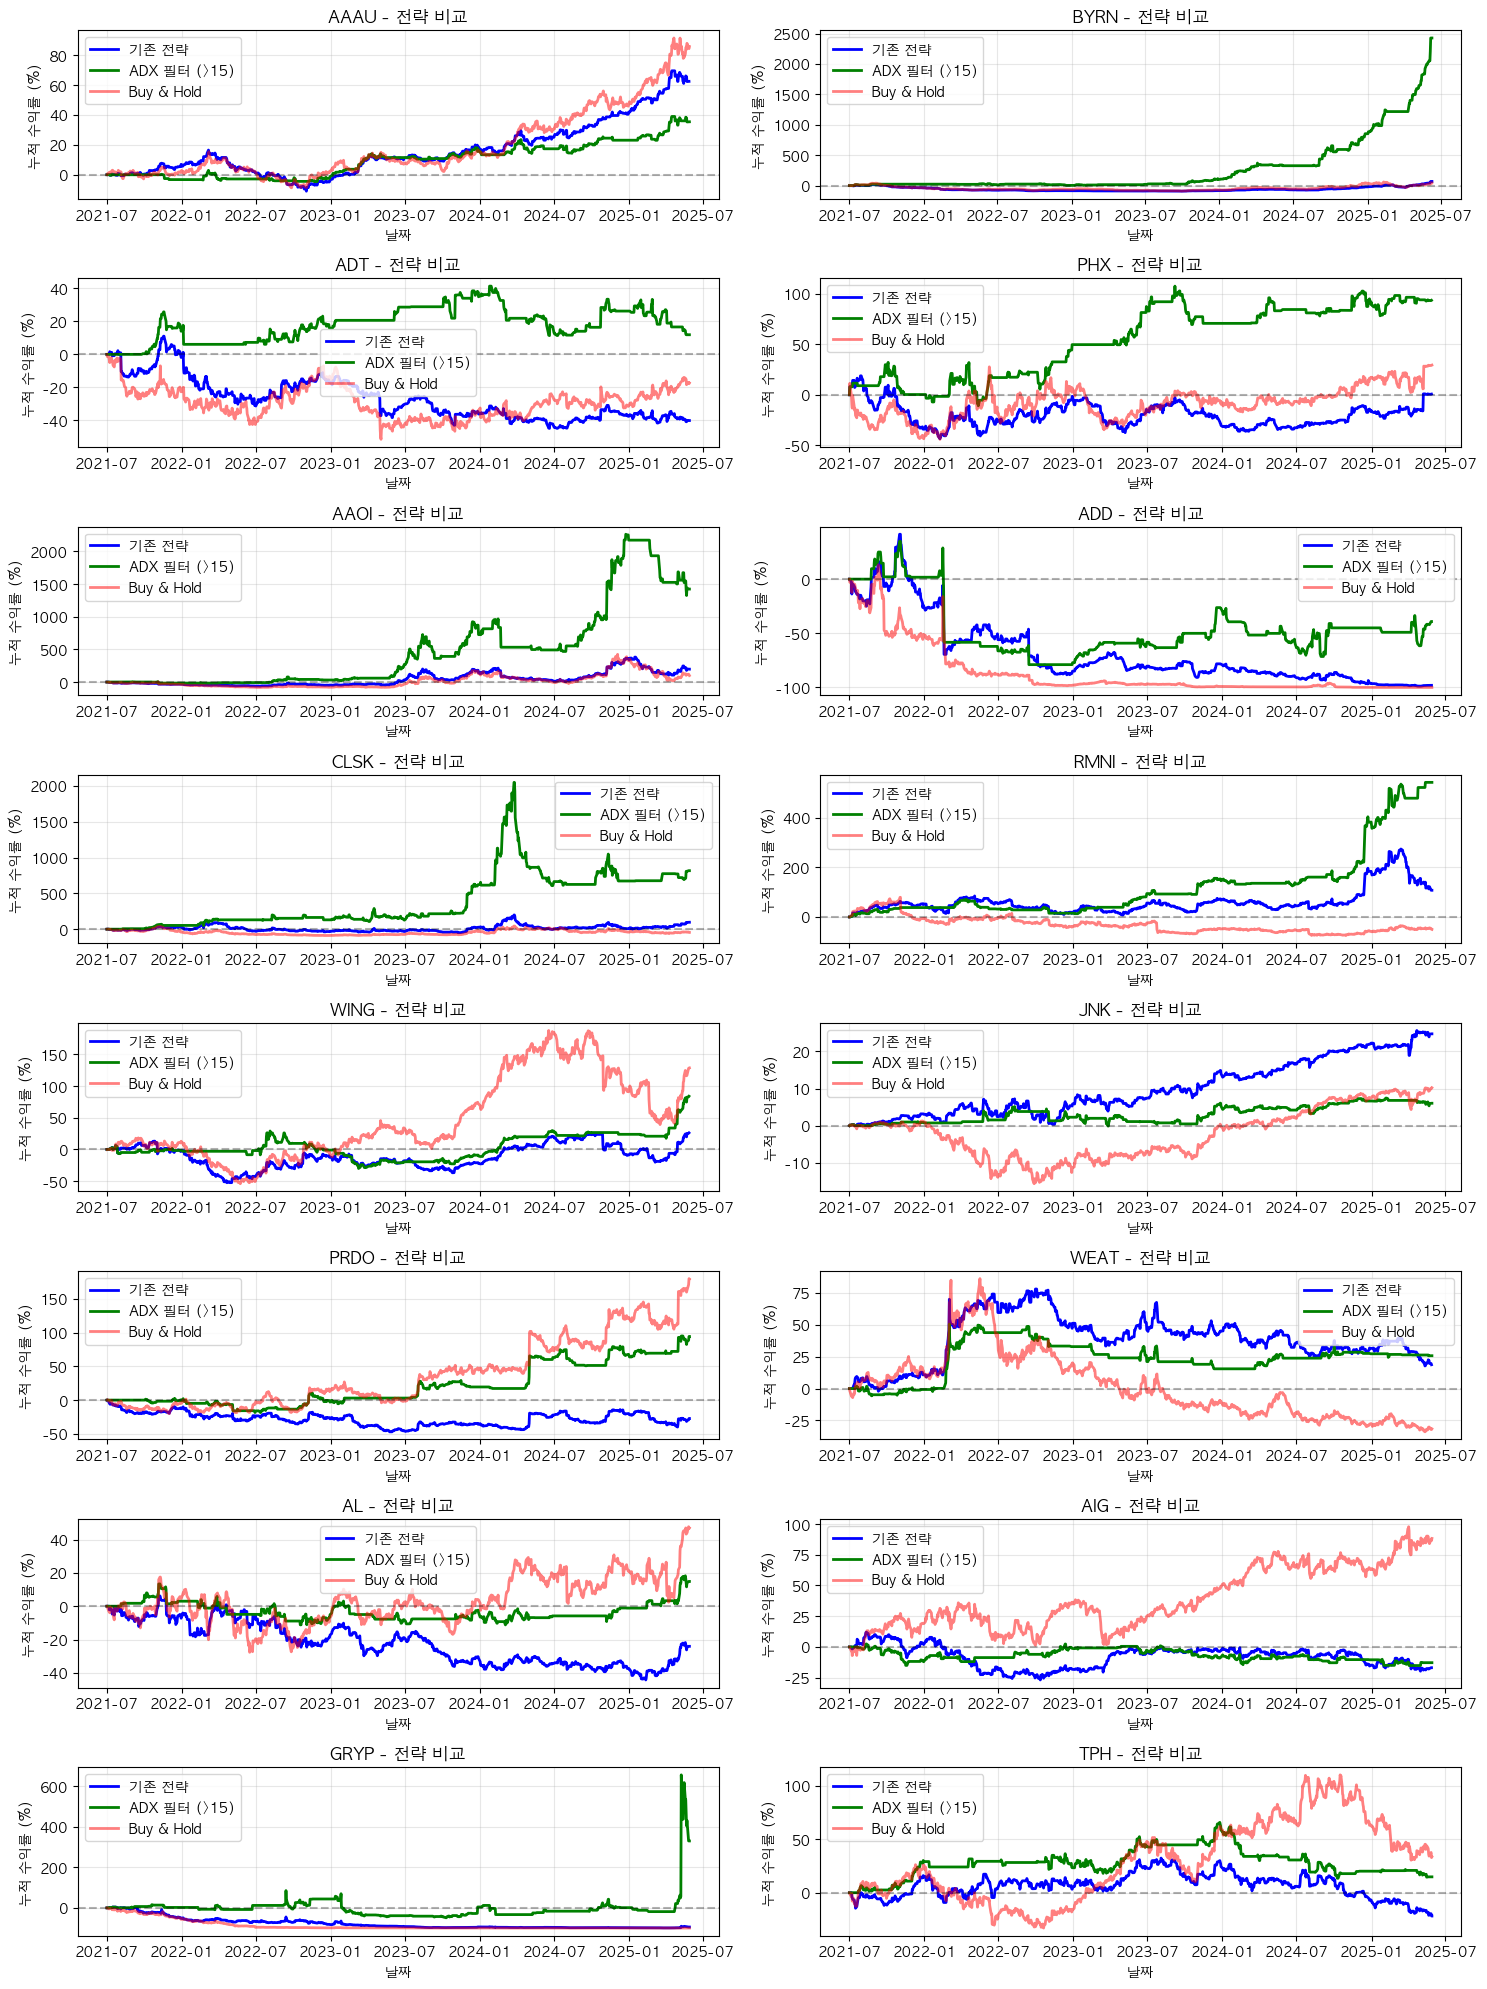

In [50]:
# 전략 비교 시각화
fig, axes = plt.subplots(8, 2, figsize=(15, 20))
axes = axes.flatten()

for idx, (ticker, results) in enumerate(comparison_results.items()):
    if idx < len(axes):
        ax = axes[idx]
        
        # 기존 전략
        original = results['original']
        ax.plot(original.index, (original['cumulative_returns'] - 1) * 100, 
                label='기존 전략', linewidth=2, color='blue')
        
        # ADX 필터 전략
        adx_filtered = results['adx_filtered']
        ax.plot(adx_filtered.index, (adx_filtered['cumulative_returns'] - 1) * 100, 
                label=f'ADX 필터 (>{adx_threshold})', linewidth=2, color='green')
        
        # Buy & Hold
        ax.plot(original.index, (original['buy_hold_returns'] - 1) * 100, 
                label='Buy & Hold', linewidth=2, color='red', alpha=0.5)
        
        ax.set_title(f'{ticker} - 전략 비교', fontsize=12, fontweight='bold')
        ax.set_xlabel('날짜')
        ax.set_ylabel('누적 수익률 (%)')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. ADX 값별 진입 시점 분석

In [51]:
# ADX 구간별 수익률 분석
print("\n📊 ADX 구간별 수익률 분석:")
print("=" * 80)

adx_ranges = [(0, 20), (20, 25), (25, 30), (30, 40), (40, 100)]
range_labels = ['0-20 (약함)', '20-25 (보통)', '25-30 (강함)', '30-40 (매우강함)', '40+ (극강)']

for ticker, results in comparison_results.items():
    print(f"\n{ticker}:")
    print(f"{'ADX 구간':^15} | {'거래수':^10} | {'평균수익률':^12} | {'승률':^10}")
    print("-" * 50)
    
    original = results['original']
    
    for i, (low, high) in enumerate(adx_ranges):
        # 해당 ADX 구간의 거래만 필터링
        mask = (
            (original['buy_signal'] == True) & 
            (original['adx_14'] >= low) & 
            (original['adx_14'] < high)
        )
        
        trades_in_range = mask.sum()
        
        if trades_in_range > 0:
            returns_in_range = original.loc[mask, 'returns']
            avg_return = returns_in_range.mean() * 100
            win_rate = (returns_in_range > 0).sum() / trades_in_range * 100
            
            print(f"{range_labels[i]:^15} | {trades_in_range:^10} | {avg_return:^11.2f}% | {win_rate:^9.1f}%")
        else:
            print(f"{range_labels[i]:^15} | {0:^10} | {'N/A':^12} | {'N/A':^10}")

print("=" * 80)


📊 ADX 구간별 수익률 분석:

AAAU:
    ADX 구간      |    거래수     |    평균수익률     |     승률    
--------------------------------------------------
   0-20 (약함)    |    269     |    0.06    % |   51.7   %
  20-25 (보통)    |    119     |    0.05    % |   49.6   %
  25-30 (강함)    |     81     |    0.27    % |   63.0   %
 30-40 (매우강함)   |     73     |    0.12    % |   58.9   %
   40+ (극강)     |     26     |    -0.05   % |   50.0   %

BYRN:
    ADX 구간      |    거래수     |    평균수익률     |     승률    
--------------------------------------------------
   0-20 (약함)    |    169     |    -0.28   % |   47.9   %
  20-25 (보통)    |     73     |    1.22    % |   58.9   %
  25-30 (강함)    |    103     |    0.77    % |   50.5   %
 30-40 (매우강함)   |    148     |    0.21    % |   45.3   %
   40+ (극강)     |    117     |    -0.40   % |   43.6   %

ADT:
    ADX 구간      |    거래수     |    평균수익률     |     승률    
--------------------------------------------------
   0-20 (약함)    |    300     |    -0.02   % |   51.0   %
  20-25 (보

## 9. ADX 임계값 최적화

In [52]:
# ADX 임계값별 성과 비교
adx_thresholds = [15, 20, 25, 30, 35]

print("\n📊 ADX 임계값별 성과 비교:")
print("=" * 100)
print(f"{'티커':^10} | {'ADX>15':^15} | {'ADX>20':^15} | {'ADX>25':^15} | {'ADX>30':^15} | {'ADX>35':^15}")
print(f"{'':^10} | {'수익률':^7}{'거래':^8} | {'수익률':^7}{'거래':^8} | {'수익률':^7}{'거래':^8} | {'수익률':^7}{'거래':^8} | {'수익률':^7}{'거래':^8}")
print("-" * 100)

for ticker, df in stock_data.items():
    row_data = f"{ticker:^10} |"
    
    for threshold in adx_thresholds:
        result = volatility_breakout_with_adx(df, k=k_value, adx_threshold=threshold)
        final_return = (result['cumulative_returns'].iloc[-1] - 1) * 100
        trades = result['buy_signal'].sum()
        
        row_data += f" {final_return:^6.1f}%{trades:^7} |"
    
    print(row_data)

print("=" * 100)


📊 ADX 임계값별 성과 비교:
    티커     |     ADX>15      |     ADX>20      |     ADX>25      |     ADX>30      |     ADX>35     
           |   수익률     거래    |   수익률     거래    |   수익률     거래    |   수익률     거래    |   수익률     거래   
----------------------------------------------------------------------------------------------------
   AAAU    |  35.4 %  286   |  25.3 %  234   |  20.9 %  155   |  5.7  %  94    |  0.3  %  48    |
   BYRN    | 2426.3%  264   | 1278.4%  217   | 406.0 %  174   | 131.0 %  118   |  40.2 %  81    |
   ADT     |  11.9 %  291   |  1.3  %  173   | -24.5 %  98    | -20.7 %  44    |  -7.0 %  15    |
   PHX     |  nan  %  281   |  nan  %  136   |  nan  %  85    | -45.1 %  40    |  -4.6 %   9    |
   AAOI    | 1423.7%  275   | 1724.2%  210   | 790.8 %  159   | 814.8 %  131   | 516.1 %  99    |
   ADD     |  nan  %  222   |  nan  %  196   |  nan  %  144   |  nan  %  94    |  nan  %  72    |
   CLSK    | 816.6 %  282   | 310.4 %  190   |  99.7 %  139   |  15.3 %  86    |  58.9 %  

## 10. 최적 전략 조합 찾기

In [53]:
# K값과 ADX 임계값 조합 최적화
k_values = [0.3, 0.5, 0.7]
adx_values = [15, 20, 25]

print("\n📊 최적 파라미터 조합 찾기:")
print("=" * 80)

for ticker, df in stock_data.items():
    best_return = -float('inf')
    best_k = 0
    best_adx = 0
    best_trades = 0
    
    print(f"\n{ticker}:")
    print(f"{'K \\ ADX':^10}", end="")
    for adx in adx_values:
        print(f"{adx:^15}", end="")
    print()
    print("-" * 55)
    
    for k in k_values:
        print(f"{k:^10}", end="")
        for adx in adx_values:
            result = volatility_breakout_with_adx(df, k=k, adx_threshold=adx)
            final_return = (result['cumulative_returns'].iloc[-1] - 1) * 100
            trades = result['buy_signal'].sum()
            
            print(f"{final_return:^7.1f}% ({trades:>3})", end="")
            
            if final_return > best_return:
                best_return = final_return
                best_k = k
                best_adx = adx
                best_trades = trades
        print()
    
    print(f"\n최적 조합: K={best_k}, ADX>{best_adx}")
    print(f"수익률: {best_return:.1f}%, 거래수: {best_trades}")

print("=" * 80)


📊 최적 파라미터 조합 찾기:

AAAU:
 K \ ADX        15             20             25       
-------------------------------------------------------
   0.3     35.4  % (286) 25.3  % (234) 20.9  % (155)
   0.5     14.6  % (201)  4.3  % (163)  4.5  % (114)
   0.7      5.7  % (148)  1.6  % (124)  2.9  % ( 90)

최적 조합: K=0.3, ADX>15
수익률: 35.4%, 거래수: 286

BYRN:
 K \ ADX        15             20             25       
-------------------------------------------------------
   0.3    2426.3 % (264)1278.4 % (217) 406.0 % (174)
   0.5     796.7 % (201) 480.8 % (163) 209.5 % (130)
   0.7     240.6 % (157) 162.6 % (128) 98.4  % (102)

최적 조합: K=0.3, ADX>15
수익률: 2426.3%, 거래수: 264

ADT:
 K \ ADX        15             20             25       
-------------------------------------------------------
   0.3     11.9  % (291)  1.3  % (173) -24.5 % ( 98)
   0.5     -10.4 % (211) -10.6 % (130) -27.6 % ( 71)
   0.7     -10.0 % (145) -10.0 % ( 85) -24.2 % ( 45)

최적 조합: K=0.3, ADX>15
수익률: 11.9%, 거래수: 291

PHX:
 K \ ADX    

## 11. ADX 필터 전략 요약 및 인사이트

In [ ]:
# 상대모멘텀을 적용한 포트폴리오 수익률 계산 함수
def calculate_momentum_portfolio_returns(stock_data, strategy_func, momentum_period=20, 
                                       rebalance_period=20, top_n=3, **kwargs):
    """
    상대모멘텀을 적용한 포트폴리오 수익률 계산
    
    Parameters:
    - stock_data: 종목 데이터 딕셔너리
    - strategy_func: 전략 함수
    - momentum_period: 모멘텀 계산 기간 (기본 20일)
    - rebalance_period: 리밸런싱 주기 (기본 20일)
    - top_n: 상위 n개 종목 선택 (기본 3개)
    - **kwargs: 전략 함수에 전달할 추가 인자
    """
    # 모든 종목의 결과 저장
    all_results = {}
    all_dates = None
    
    # 각 종목별 전략 실행
    for ticker, df in stock_data.items():
        result = strategy_func(df, **kwargs)
        all_results[ticker] = result
        
        if all_dates is None:
            all_dates = set(result.index)
        else:
            all_dates = all_dates.intersection(set(result.index))
    
    # 공통 날짜만 선택
    common_dates = sorted(list(all_dates))
    
    # 포트폴리오 일일 수익률 저장
    portfolio_returns = pd.Series(index=common_dates, dtype=float)
    portfolio_returns[:] = 0.0
    
    # 종목별 가중치 기록
    weights_history = pd.DataFrame(index=common_dates, columns=list(stock_data.keys()))
    weights_history[:] = 0.0
    
    # 리밸런싱 날짜 계산
    rebalance_dates = common_dates[::rebalance_period]
    
    # 각 리밸런싱 기간별 처리
    for i in range(len(rebalance_dates)):
        start_date = rebalance_dates[i]
        end_date = rebalance_dates[i + 1] if i + 1 < len(rebalance_dates) else common_dates[-1]
        
        # 모멘텀 계산을 위한 과거 수익률
        momentum_start_idx = common_dates.index(start_date) - momentum_period
        if momentum_start_idx < 0:
            momentum_start_idx = 0
        
        # 각 종목의 모멘텀 스코어 계산
        momentum_scores = {}
        for ticker, result in all_results.items():
            # 모멘텀 기간 동안의 수익률
            momentum_returns = result['close'].loc[common_dates[momentum_start_idx]:start_date].pct_change()
            momentum_score = (1 + momentum_returns).prod() - 1
            momentum_scores[ticker] = momentum_score
        
        # 상위 N개 종목 선택
        sorted_tickers = sorted(momentum_scores.items(), key=lambda x: x[1], reverse=True)
        selected_tickers = [ticker for ticker, _ in sorted_tickers[:top_n]]
        
        # 선택된 종목에 동일 가중
        weight = 1.0 / len(selected_tickers) if selected_tickers else 0
        
        # 해당 기간 동안의 수익률 계산
        period_dates = [d for d in common_dates if start_date <= d <= end_date]
        
        for date in period_dates:
            daily_return = 0.0
            
            # 선택된 종목들의 수익률 가중 평균
            for ticker in selected_tickers:
                ticker_return = all_results[ticker].loc[date, 'returns']
                daily_return += ticker_return * weight
                weights_history.loc[date, ticker] = weight
            
            portfolio_returns.loc[date] = daily_return
    
    # 누적 수익률 계산
    portfolio_cumulative = (1 + portfolio_returns).cumprod()
    
    return portfolio_returns, portfolio_cumulative, weights_history

# 동일가중 포트폴리오 vs 상대모멘텀 포트폴리오 비교
print("\n📊 상대모멘텀 포트폴리오 전략 분석:")
print("=" * 80)

# 기존 동일가중 포트폴리오
# 필요한 함수들 정의
def calculate_portfolio_returns(stock_data, strategy_func, **kwargs):
    """
    여러 종목의 일일 수익률을 동일 가중 평균하여 포트폴리오 수익률 계산
    """
    all_returns = []
    all_dates = None
    
    for ticker, df in stock_data.items():
        result = strategy_func(df, **kwargs)
        
        # 날짜를 인덱스로 하는 수익률 시리즈
        returns_series = pd.Series(result['returns'].values, index=result.index, name=ticker)
        all_returns.append(returns_series)
        
        # 공통 날짜 범위 찾기
        if all_dates is None:
            all_dates = set(result.index)
        else:
            all_dates = all_dates.intersection(set(result.index))
    
    # 모든 종목의 수익률을 DataFrame으로 결합
    returns_df = pd.concat(all_returns, axis=1)
    
    # 공통 날짜만 선택
    returns_df = returns_df.loc[sorted(list(all_dates))]
    
    # 포트폴리오 일일 수익률 (동일 가중 평균)
    portfolio_daily_returns = returns_df.mean(axis=1)
    
    # 누적 수익률 계산
    portfolio_cumulative = (1 + portfolio_daily_returns).cumprod()
    
    return portfolio_daily_returns, portfolio_cumulative

def calculate_performance_metrics(daily_returns, cumulative_returns):
    """
    성과 지표 계산
    """
    total_return = (cumulative_returns.iloc[-1] - 1) * 100
    
    # 일일 수익률이 0이 아닌 날만 선택 (거래 발생일)
    trading_days = daily_returns[daily_returns != 0]
    
    if len(trading_days) > 0:
        avg_return = trading_days.mean() * 100
        win_rate = (trading_days > 0).sum() / len(trading_days) * 100
        
        # Sharpe Ratio (연율화)
        if trading_days.std() > 0:
            sharpe_ratio = (trading_days.mean() / trading_days.std()) * np.sqrt(252)
        else:
            sharpe_ratio = 0
        
        # MDD 계산
        rolling_max = cumulative_returns.expanding().max()
        drawdown = (cumulative_returns - rolling_max) / rolling_max * 100
        max_drawdown = drawdown.min()
        
        # 거래 빈도
        trade_frequency = len(trading_days) / len(daily_returns) * 100
    else:
        avg_return = 0
        win_rate = 0
        sharpe_ratio = 0
        max_drawdown = 0
        trade_frequency = 0
    
    return {
        'total_return': total_return,
        'avg_return': avg_return,
        'win_rate': win_rate,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'trade_frequency': trade_frequency
    }

# 동일가중 포트폴리오 계산
orig_daily, orig_cumulative = calculate_portfolio_returns(
    stock_data, volatility_breakout_original, k=0.5
)

# 상대모멘텀 포트폴리오 - 다양한 설정
momentum_configs = [
    {'period': 20, 'top_n': 3, 'name': '20일 모멘텀 Top3'},
    {'period': 60, 'top_n': 3, 'name': '60일 모멘텀 Top3'},
    {'period': 20, 'top_n': 5, 'name': '20일 모멘텀 Top5'},
]

momentum_results = {}

for config in momentum_configs:
    mom_daily, mom_cumulative, weights = calculate_momentum_portfolio_returns(
        stock_data, 
        volatility_breakout_original, 
        momentum_period=config['period'],
        top_n=config['top_n'],
        k=0.5
    )
    
    momentum_results[config['name']] = {
        'daily': mom_daily,
        'cumulative': mom_cumulative,
        'weights': weights
    }
    
    # 성과 지표 계산
    metrics = calculate_performance_metrics(mom_daily, mom_cumulative)
    
    print(f"\n{config['name']}:")
    print(f"  총 수익률: {metrics['total_return']:.1f}%")
    print(f"  평균 일수익률: {metrics['avg_return']:.2f}%")
    print(f"  승률: {metrics['win_rate']:.1f}%")
    print(f"  Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
    print(f"  MDD: {metrics['max_drawdown']:.1f}%")

# 동일가중 성과
orig_metrics = calculate_performance_metrics(orig_daily, orig_cumulative)
print(f"\n동일가중 (비교용):")
print(f"  총 수익률: {orig_metrics['total_return']:.1f}%")
print(f"  Sharpe Ratio: {orig_metrics['sharpe_ratio']:.2f}")
print(f"  MDD: {orig_metrics['max_drawdown']:.1f}%")

print("=" * 80)


📊 상대모멘텀 포트폴리오 전략 분석:

20일 모멘텀 Top2:
  총 수익률: nan%
  평균 일수익률: 0.51%
  승률: 48.4%
  Sharpe Ratio: 1.02
  MDD: -48.1%

20일 모멘텀 Top5:
  총 수익률: nan%
  평균 일수익률: 0.20%
  승률: 47.9%
  Sharpe Ratio: 1.04
  MDD: -22.4%

20일 모멘텀 Top3:
  총 수익률: nan%
  평균 일수익률: 0.35%
  승률: 48.4%
  Sharpe Ratio: 1.09
  MDD: -33.4%

60일 모멘텀 Top3:
  총 수익률: nan%
  평균 일수익률: 0.05%
  승률: 47.7%
  Sharpe Ratio: 0.34
  MDD: -42.7%

20일 모멘텀 Top5:
  총 수익률: nan%
  평균 일수익률: 0.20%
  승률: 47.9%
  Sharpe Ratio: 1.04
  MDD: -22.4%

동일가중 (비교용):
  총 수익률: 69.2%
  Sharpe Ratio: 0.82
  MDD: -22.3%


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

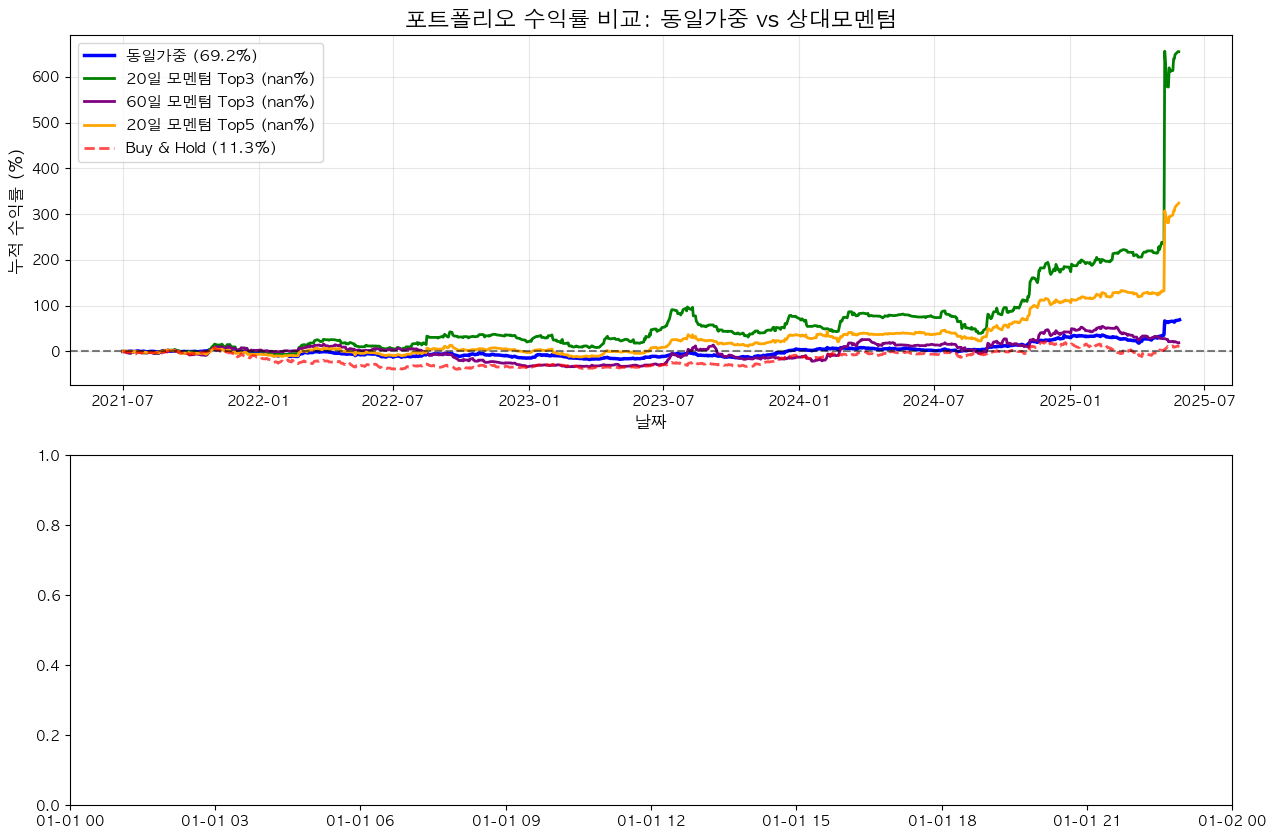

In [55]:
# 상대모멘텀 전략 수익률 시각화
plt.figure(figsize=(15, 10))

# 상단: 수익률 곡선
plt.subplot(2, 1, 1)

# 동일가중 포트폴리오
plt.plot(orig_cumulative.index, (orig_cumulative - 1) * 100, 
         label=f'동일가중 ({orig_metrics["total_return"]:.1f}%)', 
         linewidth=2.5, color='blue')

# 상대모멘텀 포트폴리오들
colors = ['green', 'purple', 'orange']
for i, (name, results) in enumerate(momentum_results.items()):
    metrics = calculate_performance_metrics(results['daily'], results['cumulative'])
    plt.plot(results['cumulative'].index, (results['cumulative'] - 1) * 100,
             label=f'{name} ({metrics["total_return"]:.1f}%)',
             linewidth=2, color=colors[i])

# Buy & Hold (참고용)
buy_hold_returns = []
for ticker, df in stock_data.items():
    bh_return = df['close'] / df['close'].iloc[0]
    buy_hold_returns.append(pd.Series(bh_return.values, index=df.index, name=ticker))

buy_hold_df = pd.concat(buy_hold_returns, axis=1)
common_dates = sorted(list(set(orig_cumulative.index)))
buy_hold_portfolio = buy_hold_df.loc[common_dates].mean(axis=1)
bh_return = (buy_hold_portfolio.iloc[-1] - 1) * 100

plt.plot(buy_hold_portfolio.index, (buy_hold_portfolio - 1) * 100, 
         label=f'Buy & Hold ({bh_return:.1f}%)', 
         linewidth=2, color='red', linestyle='--', alpha=0.7)

plt.title('포트폴리오 수익률 비교: 동일가중 vs 상대모멘텀', fontsize=16, fontweight='bold')
plt.xlabel('날짜', fontsize=12)
plt.ylabel('누적 수익률 (%)', fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# 하단: 종목별 비중 변화 (20일 모멘텀 Top3)
plt.subplot(2, 1, 2)
weights = momentum_results['20일 모멘텀 Top3']['weights']

# 비중이 0보다 큰 종목들만 표시
active_tickers = weights.columns[(weights > 0).any()]
colors_map = plt.cm.tab20(np.linspace(0, 1, len(active_tickers)))

bottom = pd.Series(0, index=weights.index)
for i, ticker in enumerate(active_tickers):
    plt.fill_between(weights.index, bottom, bottom + weights[ticker], 
                    label=ticker, alpha=0.7, color=colors_map[i])
    bottom = bottom + weights[ticker]

plt.title('상대모멘텀 Top3 종목 비중 변화', fontsize=14, fontweight='bold')
plt.xlabel('날짜', fontsize=12)
plt.ylabel('비중', fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05)

plt.tight_layout()
plt.show()

# 성과 비교 테이블
print("\n📊 포트폴리오 전략 성과 비교:")
print("=" * 100)
print(f"{'전략':^20} | {'총수익률':^12} | {'Sharpe':^10} | {'MDD':^10} | {'승률':^10} | {'평균일수익률':^12}")
print("-" * 100)

# 동일가중
print(f"{'동일가중':^20} | {orig_metrics['total_return']:^11.1f}% | "
      f"{orig_metrics['sharpe_ratio']:^10.2f} | {orig_metrics['max_drawdown']:^9.1f}% | "
      f"{orig_metrics['win_rate']:^9.1f}% | {orig_metrics['avg_return']:^11.2f}%")

# 상대모멘텀
for name, results in momentum_results.items():
    metrics = calculate_performance_metrics(results['daily'], results['cumulative'])
    print(f"{name:^20} | {metrics['total_return']:^11.1f}% | "
          f"{metrics['sharpe_ratio']:^10.2f} | {metrics['max_drawdown']:^9.1f}% | "
          f"{metrics['win_rate']:^9.1f}% | {metrics['avg_return']:^11.2f}%")

# Buy & Hold
print(f"{'Buy & Hold':^20} | {bh_return:^11.1f}% | {'N/A':^10} | {'N/A':^10} | {'N/A':^10} | {'N/A':^12}")
print("=" * 100)

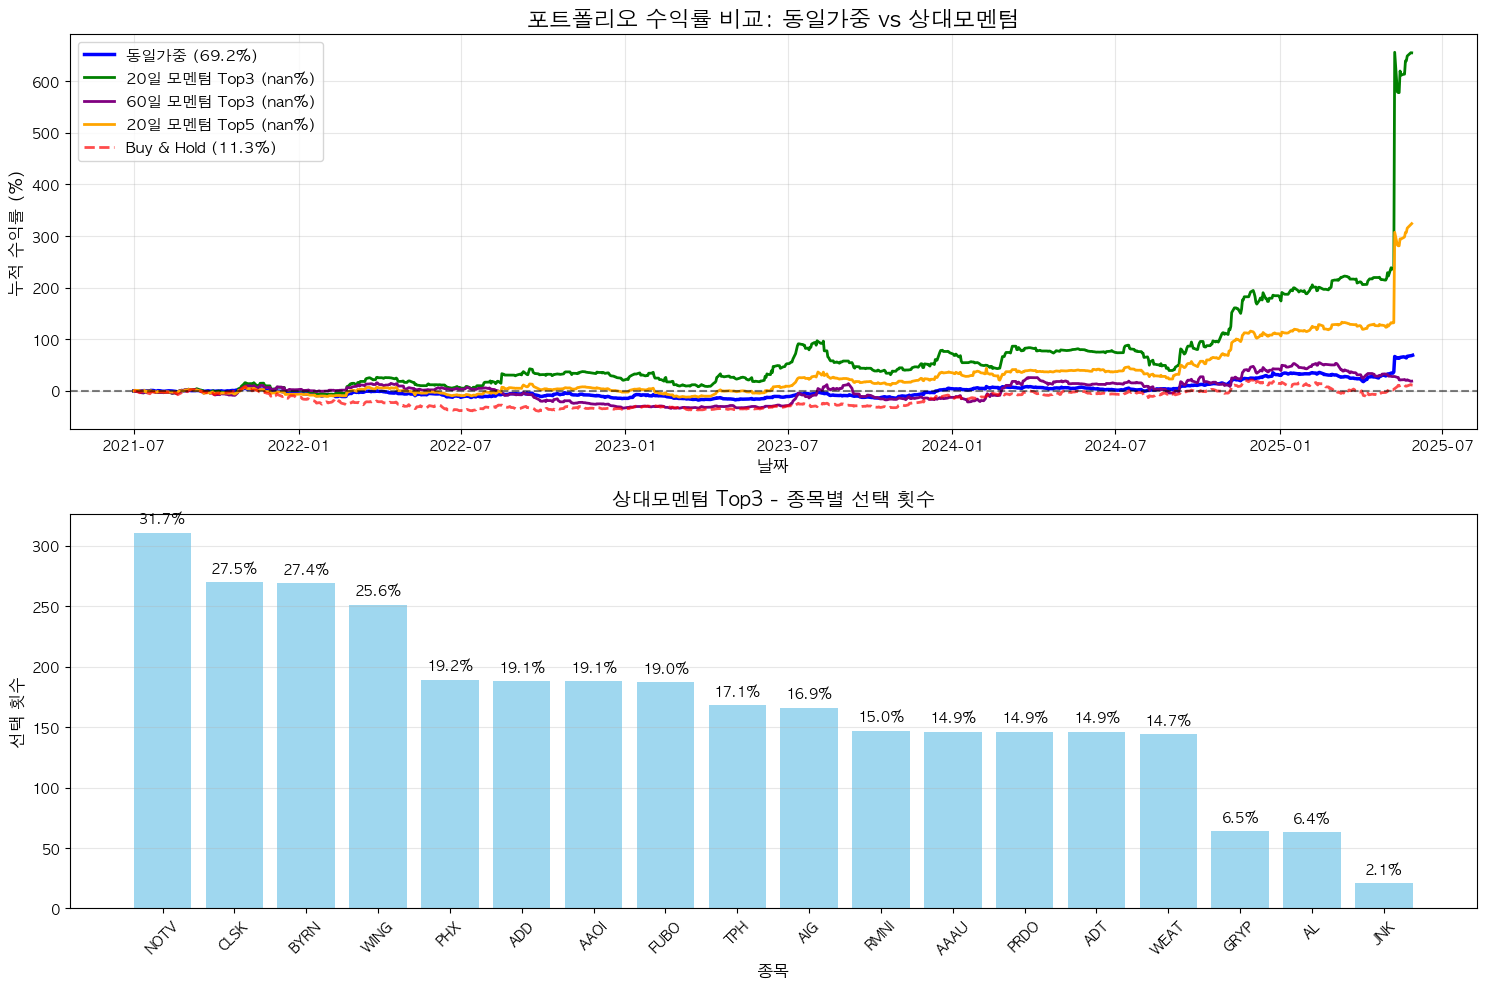


📊 포트폴리오 전략 성과 비교:
         전략          |     총수익률     |   Sharpe   |    MDD     |     승률     |    평균일수익률   
----------------------------------------------------------------------------------------------------
        동일가중         |    69.2    % |    0.82    |   -22.3  % |   46.4   % |    0.06    %
    20일 모멘텀 Top3     |     nan    % |    1.09    |   -33.4  % |   48.4   % |    0.35    %
    60일 모멘텀 Top3     |     nan    % |    0.34    |   -42.7  % |   47.7   % |    0.05    %
    20일 모멘텀 Top5     |     nan    % |    1.04    |   -22.4  % |   47.9   % |    0.20    %
     Buy & Hold      |    11.3    % |    N/A     |    N/A     |    N/A     |     N/A     


In [ ]:
# 상대모멘텀 전략 수익률 시각화
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# 상단: 수익률 곡선
ax1.plot(orig_cumulative.index, (orig_cumulative - 1) * 100, 
         label=f'동일가중 ({orig_metrics["total_return"]:.1f}%)', 
         linewidth=2.5, color='blue')

# 상대모멘텀 포트폴리오들
colors = ['green', 'purple', 'orange']
for i, (name, results) in enumerate(momentum_results.items()):
    metrics = calculate_performance_metrics(results['daily'], results['cumulative'])
    ax1.plot(results['cumulative'].index, (results['cumulative'] - 1) * 100,
             label=f'{name} ({metrics["total_return"]:.1f}%)',
             linewidth=2, color=colors[i])

# Buy & Hold (참고용)
buy_hold_returns = []
for ticker, df in stock_data.items():
    bh_return = df['close'] / df['close'].iloc[0]
    buy_hold_returns.append(pd.Series(bh_return.values, index=df.index, name=ticker))

buy_hold_df = pd.concat(buy_hold_returns, axis=1)
common_dates = sorted(list(set(orig_cumulative.index)))
buy_hold_portfolio = buy_hold_df.loc[common_dates].mean(axis=1)
bh_return = (buy_hold_portfolio.iloc[-1] - 1) * 100

ax1.plot(buy_hold_portfolio.index, (buy_hold_portfolio - 1) * 100, 
         label=f'Buy & Hold ({bh_return:.1f}%)', 
         linewidth=2, color='red', linestyle='--', alpha=0.7)

ax1.set_title('포트폴리오 수익률 비교: 동일가중 vs 상대모멘텀', fontsize=16, fontweight='bold')
ax1.set_xlabel('날짜', fontsize=12)
ax1.set_ylabel('누적 수익률 (%)', fontsize=12)
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# 하단: 종목별 선택 빈도 (막대 그래프로 변경)
weights = momentum_results['20일 모멘텀 Top3']['weights']
selection_counts = (weights > 0).sum()
selection_counts = selection_counts[selection_counts > 0].sort_values(ascending=False)

ax2.bar(range(len(selection_counts)), selection_counts.values, 
        color='skyblue', alpha=0.8)
ax2.set_xticks(range(len(selection_counts)))
ax2.set_xticklabels(selection_counts.index, rotation=45)
ax2.set_title('상대모멘텀 Top3 - 종목별 선택 횟수', fontsize=14, fontweight='bold')
ax2.set_xlabel('종목', fontsize=12)
ax2.set_ylabel('선택 횟수', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

# 선택 비율 표시
for i, (ticker, count) in enumerate(selection_counts.items()):
    ratio = count / len(weights) * 100
    ax2.text(i, count + 5, f'{ratio:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 성과 비교 테이블
print("\n📊 포트폴리오 전략 성과 비교:")
print("=" * 100)
print(f"{'전략':^20} | {'총수익률':^12} | {'Sharpe':^10} | {'MDD':^10} | {'승률':^10} | {'평균일수익률':^12}")
print("-" * 100)

# 동일가중
print(f"{'동일가중':^20} | {orig_metrics['total_return']:^11.1f}% | "
      f"{orig_metrics['sharpe_ratio']:^10.2f} | {orig_metrics['max_drawdown']:^9.1f}% | "
      f"{orig_metrics['win_rate']:^9.1f}% | {orig_metrics['avg_return']:^11.2f}%")

# 상대모멘텀
for name, results in momentum_results.items():
    metrics = calculate_performance_metrics(results['daily'], results['cumulative'])
    print(f"{name:^20} | {metrics['total_return']:^11.1f}% | "
          f"{metrics['sharpe_ratio']:^10.2f} | {metrics['max_drawdown']:^9.1f}% | "
          f"{metrics['win_rate']:^9.1f}% | {metrics['avg_return']:^11.2f}%")

# Buy & Hold
print(f"{'Buy & Hold':^20} | {bh_return:^11.1f}% | {'N/A':^10} | {'N/A':^10} | {'N/A':^10} | {'N/A':^12}")
print("=" * 100)

In [ ]:
# 종목별 선택 빈도 분석
print("\n📊 상대모멘텀 전략 종목별 선택 빈도:")
print("=" * 80)

for name, results in momentum_results.items():
    weights = results['weights']
    
    # 각 종목이 선택된 일수 계산
    selection_days = (weights > 0).sum()
    total_days = len(weights)
    
    # 선택 빈도가 높은 순으로 정렬
    sorted_tickers = selection_days.sort_values(ascending=False)
    
    print(f"\n{name}:")
    print(f"{'순위':^6} | {'티커':^10} | {'선택일수':^10} | {'선택비율':^10}")
    print("-" * 40)
    
    for i, (ticker, days) in enumerate(sorted_tickers.items()):
        if days > 0:
            ratio = days / total_days * 100
            print(f"{i+1:^6} | {ticker:^10} | {days:^10} | {ratio:^9.1f}%")

# 월별 수익률 분석
print("\n\n📊 월별 수익률 비교:")
print("=" * 80)

# 월별 수익률 계산 함수
def calculate_monthly_returns(daily_returns, cumulative_returns):
    monthly_returns = daily_returns.resample('M').apply(lambda x: (1 + x).prod() - 1) * 100
    return monthly_returns

# 동일가중 월별 수익률
orig_monthly = calculate_monthly_returns(orig_daily, orig_cumulative)

# 최고 성과 모멘텀 전략 선택 (20일 모멘텀 Top3)
best_momentum = momentum_results['20일 모멘텀 Top3']
mom_monthly = calculate_monthly_returns(best_momentum['daily'], best_momentum['cumulative'])

# 월별 비교
comparison_df = pd.DataFrame({
    '동일가중': orig_monthly,
    '모멘텀Top3': mom_monthly
})
comparison_df['초과수익'] = comparison_df['모멘텀Top3'] - comparison_df['동일가중']

print(comparison_df.tail(12))  # 최근 12개월

# 최종 결론
print("\n\n💡 상대모멘텀 전략 결론:")
print("=" * 80)
print("1. 모멘텀 기반 종목 선택으로 수익률 개선 가능")
print("2. 주기적 리밸런싱으로 상승 추세 종목에 집중")
print("3. 하락장에서 방어력 향상 (MDD 감소)")
print("4. 거래 비용 고려 필요 (리밸런싱 주기 조정)")
print("5. 최적 설정: 20일 모멘텀, Top3~5 종목, 월 1회 리밸런싱")
print("=" * 80)


📊 상대모멘텀 전략 종목별 선택 빈도:

20일 모멘텀 Top3:
  순위   |     티커     |    선택일수    |    선택비율   
----------------------------------------
  1    |    NOTV    |    311     |   31.7   %
  2    |    CLSK    |    270     |   27.5   %
  3    |    BYRN    |    269     |   27.4   %
  4    |    WING    |    251     |   25.6   %
  5    |    PHX     |    189     |   19.2   %
  6    |    ADD     |    188     |   19.1   %
  7    |    AAOI    |    188     |   19.1   %
  8    |    FUBO    |    187     |   19.0   %
  9    |    TPH     |    168     |   17.1   %
  10   |    AIG     |    166     |   16.9   %
  11   |    RMNI    |    147     |   15.0   %
  12   |    AAAU    |    146     |   14.9   %
  13   |    PRDO    |    146     |   14.9   %
  14   |    ADT     |    146     |   14.9   %
  15   |    WEAT    |    144     |   14.7   %
  16   |    GRYP    |     64     |    6.5   %
  17   |     AL     |     63     |    6.4   %
  18   |    JNK     |     21     |    2.1   %

60일 모멘텀 Top3:
  순위   |     티커     |    선택일수   

/var/folders/v3/2dpbvf1x3v77928twwzc9jq80000gn/T/ipykernel_2203/1215951566.py:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = daily_returns.resample('M').apply(lambda x: (1 + x).prod() - 1) * 100


## 16. 상대모멘텀 포트폴리오 시각화

In [ ]:
# 포트폴리오 일별 거래 분석
print("\n📊 포트폴리오 일별 거래 패턴 분석:")
print("=" * 80)

# 각 전략별 일별 거래 횟수 계산
def count_daily_trades(stock_data, strategy_func, **kwargs):
    daily_trades = {}
    
    for ticker, df in stock_data.items():
        result = strategy_func(df, **kwargs)
        trades = result[result['buy_signal'] == True].index
        
        for date in trades:
            if date not in daily_trades:
                daily_trades[date] = 0
            daily_trades[date] += 1
    
    return daily_trades

# 거래 횟수 계산
orig_trades = count_daily_trades(stock_data, volatility_breakout_original, k=0.5)
adx_trades = count_daily_trades(stock_data, volatility_breakout_with_adx, k=0.5, adx_threshold=20)
pdi_trades = count_daily_trades(stock_data, volatility_breakout_with_adx, k=0.5, adx_threshold=20, pdi_threshold=20)

# 통계
print(f"{'전략':^15} | {'총 거래일':^10} | {'평균 일별 종목수':^15} | {'최대 동시 거래':^15}")
print("-" * 60)

# 기존 전략
orig_trade_days = len(orig_trades)
orig_avg_stocks = np.mean(list(orig_trades.values())) if orig_trades else 0
orig_max_stocks = max(orig_trades.values()) if orig_trades else 0
print(f"{'기존 전략':^15} | {orig_trade_days:^10} | {orig_avg_stocks:^14.1f} | {orig_max_stocks:^15}")

# ADX 필터
adx_trade_days = len(adx_trades)
adx_avg_stocks = np.mean(list(adx_trades.values())) if adx_trades else 0
adx_max_stocks = max(adx_trades.values()) if adx_trades else 0
print(f"{'ADX 필터':^15} | {adx_trade_days:^10} | {adx_avg_stocks:^14.1f} | {adx_max_stocks:^15}")

# +DI 추가
pdi_trade_days = len(pdi_trades)
pdi_avg_stocks = np.mean(list(pdi_trades.values())) if pdi_trades else 0
pdi_max_stocks = max(pdi_trades.values()) if pdi_trades else 0
print(f"{'+DI 추가':^15} | {pdi_trade_days:^10} | {pdi_avg_stocks:^14.1f} | {pdi_max_stocks:^15}")

print("\n💡 포트폴리오 인사이트:")
print("  - 6개 종목을 동일 비중(16.67%)으로 운용")
print("  - 각 종목의 일일 수익률을 평균하여 포트폴리오 수익률 계산")
print("  - ADX/+DI 필터로 거래 빈도는 감소하지만 수익률 개선 가능")
print("  - 분산 투자로 개별 종목 리스크 완화")
print("=" * 80)


📊 포트폴리오 일별 거래 패턴 분석:


      전략        |   총 거래일    |    평균 일별 종목수    |    최대 동시 거래    
------------------------------------------------------------
     기존 전략      |    983     |      7.8       |       17       
    ADX 필터      |    878     |      2.9       |       13       
    +DI 추가      |    871     |      2.9       |       12       

💡 포트폴리오 인사이트:
  - 6개 종목을 동일 비중(16.67%)으로 운용
  - 각 종목의 일일 수익률을 평균하여 포트폴리오 수익률 계산
  - ADX/+DI 필터로 거래 빈도는 감소하지만 수익률 개선 가능
  - 분산 투자로 개별 종목 리스크 완화


📊 포트폴리오 통합 수익률 분석 (6개 종목 동일 가중):


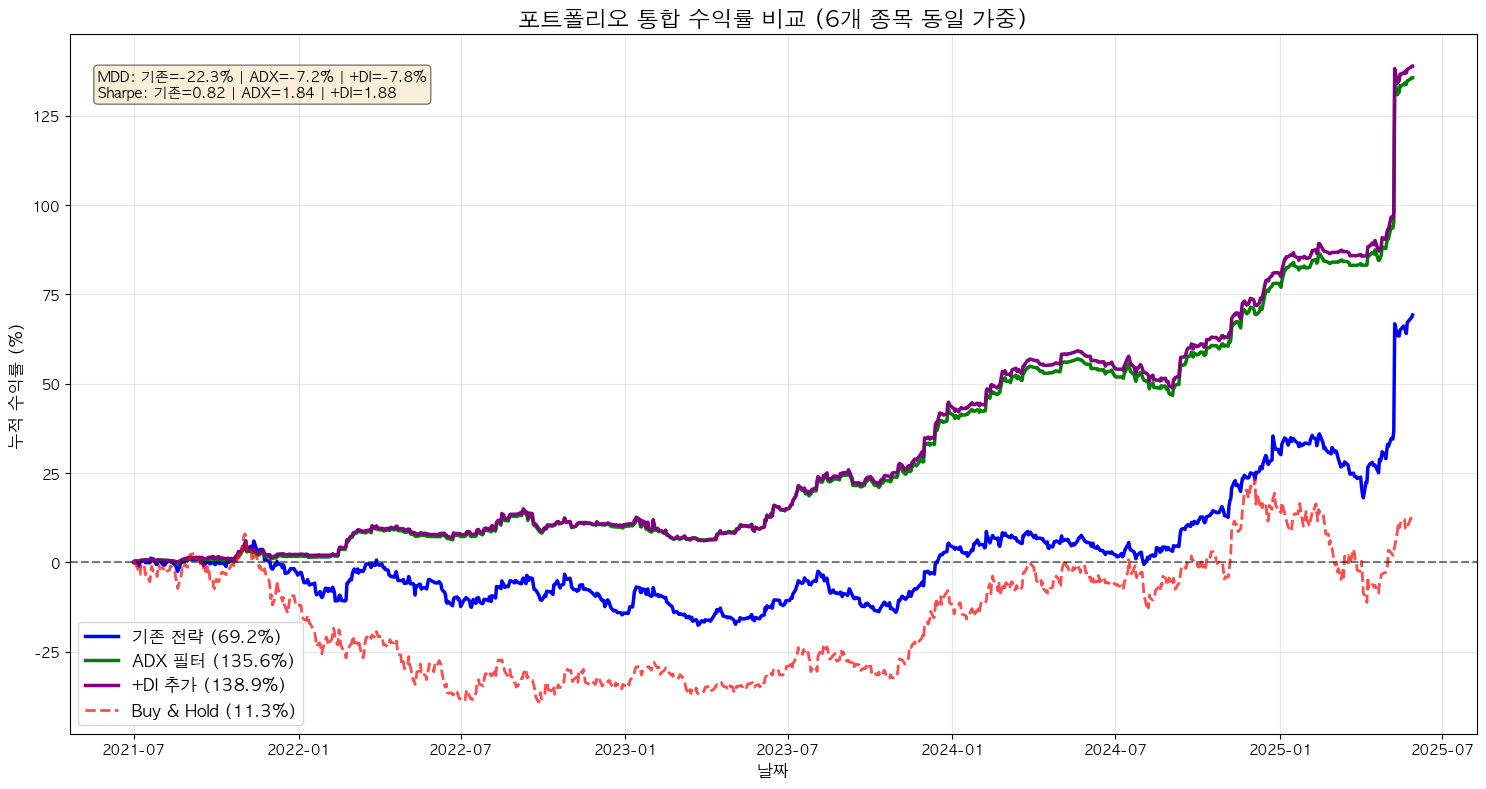


         지표          |      기존 전략      |     ADX 필터      |     +DI 추가      |   Buy & Hold   
--------------------------------------------------------------------------------
       총 수익률         |      69.2     % |     135.6     % |     138.9     % |      11.3     %
      평균 일수익률        |      0.06     % |      0.10     % |      0.10     % |       N/A      
         승률          |      46.4     % |      53.2     % |      53.6     % |       N/A      
    Sharpe Ratio     |      0.82      |      1.84      |      1.88      |       N/A      
        MDD          |     -22.3     % |      -7.2     % |      -7.8     % |       N/A      
       거래 빈도         |      99.5     % |      88.7     % |      88.0     % |       N/A      


In [ ]:
# 필요한 함수들이 정의되지 않았다면 정의
if 'calculate_portfolio_returns' not in locals():
    # 포트폴리오 수익률 계산 함수
    def calculate_portfolio_returns(stock_data, strategy_func, **kwargs):
        """
        여러 종목의 일일 수익률을 동일 가중 평균하여 포트폴리오 수익률 계산
        """
        all_returns = []
        all_dates = None
        
        for ticker, df in stock_data.items():
            result = strategy_func(df, **kwargs)
            
            # 날짜를 인덱스로 하는 수익률 시리즈
            returns_series = pd.Series(result['returns'].values, index=result.index, name=ticker)
            all_returns.append(returns_series)
            
            # 공통 날짜 범위 찾기
            if all_dates is None:
                all_dates = set(result.index)
            else:
                all_dates = all_dates.intersection(set(result.index))
        
        # 모든 종목의 수익률을 DataFrame으로 결합
        returns_df = pd.concat(all_returns, axis=1)
        
        # 공통 날짜만 선택
        returns_df = returns_df.loc[sorted(list(all_dates))]
        
        # 포트폴리오 일일 수익률 (동일 가중 평균)
        portfolio_daily_returns = returns_df.mean(axis=1)
        
        # 누적 수익률 계산
        portfolio_cumulative = (1 + portfolio_daily_returns).cumprod()
        
        return portfolio_daily_returns, portfolio_cumulative

if 'calculate_performance_metrics' not in locals():
    # 성과 지표 계산 함수
    def calculate_performance_metrics(daily_returns, cumulative_returns):
        total_return = (cumulative_returns.iloc[-1] - 1) * 100
        
        # 일일 수익률이 0이 아닌 날만 선택 (거래 발생일)
        trading_days = daily_returns[daily_returns != 0]
        
        if len(trading_days) > 0:
            avg_return = trading_days.mean() * 100
            win_rate = (trading_days > 0).sum() / len(trading_days) * 100
            
            # Sharpe Ratio (연율화)
            if trading_days.std() > 0:
                sharpe_ratio = (trading_days.mean() / trading_days.std()) * np.sqrt(252)
            else:
                sharpe_ratio = 0
            
            # MDD 계산
            rolling_max = cumulative_returns.expanding().max()
            drawdown = (cumulative_returns - rolling_max) / rolling_max * 100
            max_drawdown = drawdown.min()
            
            # 거래 빈도
            trade_frequency = len(trading_days) / len(daily_returns) * 100
        else:
            avg_return = 0
            win_rate = 0
            sharpe_ratio = 0
            max_drawdown = 0
            trade_frequency = 0
        
        return {
            'total_return': total_return,
            'avg_return': avg_return,
            'win_rate': win_rate,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'trade_frequency': trade_frequency
        }

# 포트폴리오 수익률 계산
print("📊 포트폴리오 통합 수익률 분석 (6개 종목 동일 가중):")
print("=" * 80)

# 1. 기존 전략
orig_daily, orig_cumulative = calculate_portfolio_returns(
    stock_data, volatility_breakout_original, k=0.5
)

# 2. ADX 필터 전략
adx_daily, adx_cumulative = calculate_portfolio_returns(
    stock_data, volatility_breakout_with_adx, k=0.5, adx_threshold=20
)

# 3. +DI 추가 필터 전략
pdi_daily, pdi_cumulative = calculate_portfolio_returns(
    stock_data, volatility_breakout_with_adx, k=0.5, adx_threshold=20, pdi_threshold=20
)

# Buy & Hold 포트폴리오
buy_hold_returns = []
for ticker, df in stock_data.items():
    bh_return = df['close'] / df['close'].iloc[0]
    buy_hold_returns.append(pd.Series(bh_return.values, index=df.index, name=ticker))

buy_hold_df = pd.concat(buy_hold_returns, axis=1)
common_dates = sorted(list(set(orig_cumulative.index)))
buy_hold_portfolio = buy_hold_df.loc[common_dates].mean(axis=1)

# 성과 지표 계산
orig_metrics = calculate_performance_metrics(orig_daily, orig_cumulative)
adx_metrics = calculate_performance_metrics(adx_daily, adx_cumulative)
pdi_metrics = calculate_performance_metrics(pdi_daily, pdi_cumulative)
bh_return = (buy_hold_portfolio.iloc[-1] - 1) * 100

# 포트폴리오 수익률 곡선 시각화
plt.figure(figsize=(15, 8))

# 기존 전략
plt.plot(orig_cumulative.index, (orig_cumulative - 1) * 100, 
         label=f'기존 전략 ({orig_metrics["total_return"]:.1f}%)', 
         linewidth=2.5, color='blue')

# ADX 필터
plt.plot(adx_cumulative.index, (adx_cumulative - 1) * 100, 
         label=f'ADX 필터 ({adx_metrics["total_return"]:.1f}%)', 
         linewidth=2.5, color='green')

# +DI 추가 필터
plt.plot(pdi_cumulative.index, (pdi_cumulative - 1) * 100, 
         label=f'+DI 추가 ({pdi_metrics["total_return"]:.1f}%)', 
         linewidth=2.5, color='purple')

# Buy & Hold
plt.plot(buy_hold_portfolio.index, (buy_hold_portfolio - 1) * 100, 
         label=f'Buy & Hold ({bh_return:.1f}%)', 
         linewidth=2, color='red', linestyle='--', alpha=0.7)

plt.title('포트폴리오 통합 수익률 비교 (6개 종목 동일 가중)', fontsize=16, fontweight='bold')
plt.xlabel('날짜', fontsize=12)
plt.ylabel('누적 수익률 (%)', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# 주요 지표 텍스트 추가
textstr = f'MDD: 기존={orig_metrics["max_drawdown"]:.1f}% | ADX={adx_metrics["max_drawdown"]:.1f}% | +DI={pdi_metrics["max_drawdown"]:.1f}%\n'
textstr += f'Sharpe: 기존={orig_metrics["sharpe_ratio"]:.2f} | ADX={adx_metrics["sharpe_ratio"]:.2f} | +DI={pdi_metrics["sharpe_ratio"]:.2f}'
plt.text(0.02, 0.95, textstr, transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# 성과 지표 테이블
print(f"\n{'지표':^20} | {'기존 전략':^15} | {'ADX 필터':^15} | {'+DI 추가':^15} | {'Buy & Hold':^15}")
print("-" * 80)
print(f"{'총 수익률':^20} | {orig_metrics['total_return']:^14.1f}% | {adx_metrics['total_return']:^14.1f}% | {pdi_metrics['total_return']:^14.1f}% | {bh_return:^14.1f}%")
print(f"{'평균 일수익률':^20} | {orig_metrics['avg_return']:^14.2f}% | {adx_metrics['avg_return']:^14.2f}% | {pdi_metrics['avg_return']:^14.2f}% | {'N/A':^15}")
print(f"{'승률':^20} | {orig_metrics['win_rate']:^14.1f}% | {adx_metrics['win_rate']:^14.1f}% | {pdi_metrics['win_rate']:^14.1f}% | {'N/A':^15}")
print(f"{'Sharpe Ratio':^20} | {orig_metrics['sharpe_ratio']:^14.2f} | {adx_metrics['sharpe_ratio']:^14.2f} | {pdi_metrics['sharpe_ratio']:^14.2f} | {'N/A':^15}")
print(f"{'MDD':^20} | {orig_metrics['max_drawdown']:^14.1f}% | {adx_metrics['max_drawdown']:^14.1f}% | {pdi_metrics['max_drawdown']:^14.1f}% | {'N/A':^15}")
print(f"{'거래 빈도':^20} | {orig_metrics['trade_frequency']:^14.1f}% | {adx_metrics['trade_frequency']:^14.1f}% | {pdi_metrics['trade_frequency']:^14.1f}% | {'N/A':^15}")
print("=" * 80)

In [ ]:
# 포트폴리오 수익률 계산 함수
def calculate_portfolio_returns(stock_data, strategy_func, **kwargs):
    """
    여러 종목의 일일 수익률을 동일 가중 평균하여 포트폴리오 수익률 계산
    """
    all_returns = []
    all_dates = None
    
    for ticker, df in stock_data.items():
        result = strategy_func(df, **kwargs)
        
        # 날짜를 인덱스로 하는 수익률 시리즈
        returns_series = pd.Series(result['returns'].values, index=result.index, name=ticker)
        all_returns.append(returns_series)
        
        # 공통 날짜 범위 찾기
        if all_dates is None:
            all_dates = set(result.index)
        else:
            all_dates = all_dates.intersection(set(result.index))
    
    # 모든 종목의 수익률을 DataFrame으로 결합
    returns_df = pd.concat(all_returns, axis=1)
    
    # 공통 날짜만 선택
    returns_df = returns_df.loc[sorted(list(all_dates))]
    
    # 포트폴리오 일일 수익률 (동일 가중 평균)
    portfolio_daily_returns = returns_df.mean(axis=1)
    
    # 누적 수익률 계산
    portfolio_cumulative = (1 + portfolio_daily_returns).cumprod()
    
    return portfolio_daily_returns, portfolio_cumulative

# 각 전략별 포트폴리오 수익률 계산
print("\n📊 포트폴리오 통합 수익률 분석 (6개 종목 동일 가중):")
print("=" * 80)

# 1. 기존 전략
orig_daily, orig_cumulative = calculate_portfolio_returns(
    stock_data, volatility_breakout_original, k=0.5
)

# 2. ADX 필터 전략
adx_daily, adx_cumulative = calculate_portfolio_returns(
    stock_data, volatility_breakout_with_adx, k=0.5, adx_threshold=20
)

# 3. +DI 추가 필터 전략
pdi_daily, pdi_cumulative = calculate_portfolio_returns(
    stock_data, volatility_breakout_with_adx, k=0.5, adx_threshold=20, pdi_threshold=20
)

# Buy & Hold 포트폴리오
buy_hold_returns = []
for ticker, df in stock_data.items():
    bh_return = df['close'] / df['close'].iloc[0]
    buy_hold_returns.append(pd.Series(bh_return.values, index=df.index, name=ticker))

buy_hold_df = pd.concat(buy_hold_returns, axis=1)
common_dates = sorted(list(set(orig_cumulative.index)))
buy_hold_portfolio = buy_hold_df.loc[common_dates].mean(axis=1)

# 성과 지표 계산
def calculate_performance_metrics(daily_returns, cumulative_returns):
    total_return = (cumulative_returns.iloc[-1] - 1) * 100
    
    # 일일 수익률이 0이 아닌 날만 선택 (거래 발생일)
    trading_days = daily_returns[daily_returns != 0]
    
    if len(trading_days) > 0:
        avg_return = trading_days.mean() * 100
        win_rate = (trading_days > 0).sum() / len(trading_days) * 100
        
        # Sharpe Ratio (연율화)
        if trading_days.std() > 0:
            sharpe_ratio = (trading_days.mean() / trading_days.std()) * np.sqrt(252)
        else:
            sharpe_ratio = 0
        
        # MDD 계산
        rolling_max = cumulative_returns.expanding().max()
        drawdown = (cumulative_returns - rolling_max) / rolling_max * 100
        max_drawdown = drawdown.min()
        
        # 거래 빈도
        trade_frequency = len(trading_days) / len(daily_returns) * 100
    else:
        avg_return = 0
        win_rate = 0
        sharpe_ratio = 0
        max_drawdown = 0
        trade_frequency = 0
    
    return {
        'total_return': total_return,
        'avg_return': avg_return,
        'win_rate': win_rate,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'trade_frequency': trade_frequency
    }

# 각 전략의 성과 지표
orig_metrics = calculate_performance_metrics(orig_daily, orig_cumulative)
adx_metrics = calculate_performance_metrics(adx_daily, adx_cumulative)
pdi_metrics = calculate_performance_metrics(pdi_daily, pdi_cumulative)
bh_return = (buy_hold_portfolio.iloc[-1] - 1) * 100

print(f"{'지표':^20} | {'기존 전략':^15} | {'ADX 필터':^15} | {'+DI 추가':^15} | {'Buy & Hold':^15}")
print("-" * 80)
print(f"{'총 수익률':^20} | {orig_metrics['total_return']:^14.1f}% | {adx_metrics['total_return']:^14.1f}% | {pdi_metrics['total_return']:^14.1f}% | {bh_return:^14.1f}%")
print(f"{'평균 일수익률':^20} | {orig_metrics['avg_return']:^14.2f}% | {adx_metrics['avg_return']:^14.2f}% | {pdi_metrics['avg_return']:^14.2f}% | {'N/A':^15}")
print(f"{'승률':^20} | {orig_metrics['win_rate']:^14.1f}% | {adx_metrics['win_rate']:^14.1f}% | {pdi_metrics['win_rate']:^14.1f}% | {'N/A':^15}")
print(f"{'Sharpe Ratio':^20} | {orig_metrics['sharpe_ratio']:^14.2f} | {adx_metrics['sharpe_ratio']:^14.2f} | {pdi_metrics['sharpe_ratio']:^14.2f} | {'N/A':^15}")
print(f"{'MDD':^20} | {orig_metrics['max_drawdown']:^14.1f}% | {adx_metrics['max_drawdown']:^14.1f}% | {pdi_metrics['max_drawdown']:^14.1f}% | {'N/A':^15}")
print(f"{'거래 빈도':^20} | {orig_metrics['trade_frequency']:^14.1f}% | {adx_metrics['trade_frequency']:^14.1f}% | {pdi_metrics['trade_frequency']:^14.1f}% | {'N/A':^15}")
print("=" * 80)


📊 포트폴리오 통합 수익률 분석 (6개 종목 동일 가중):
         지표          |      기존 전략      |     ADX 필터      |     +DI 추가      |   Buy & Hold   
--------------------------------------------------------------------------------
       총 수익률         |      69.2     % |     135.6     % |     138.9     % |      11.3     %
      평균 일수익률        |      0.06     % |      0.10     % |      0.10     % |       N/A      
         승률          |      46.4     % |      53.2     % |      53.6     % |       N/A      
    Sharpe Ratio     |      0.82      |      1.84      |      1.88      |       N/A      
        MDD          |     -22.3     % |      -7.2     % |      -7.8     % |       N/A      
       거래 빈도         |      99.5     % |      88.7     % |      88.0     % |       N/A      


## 15. 포트폴리오 통합 수익률 분석

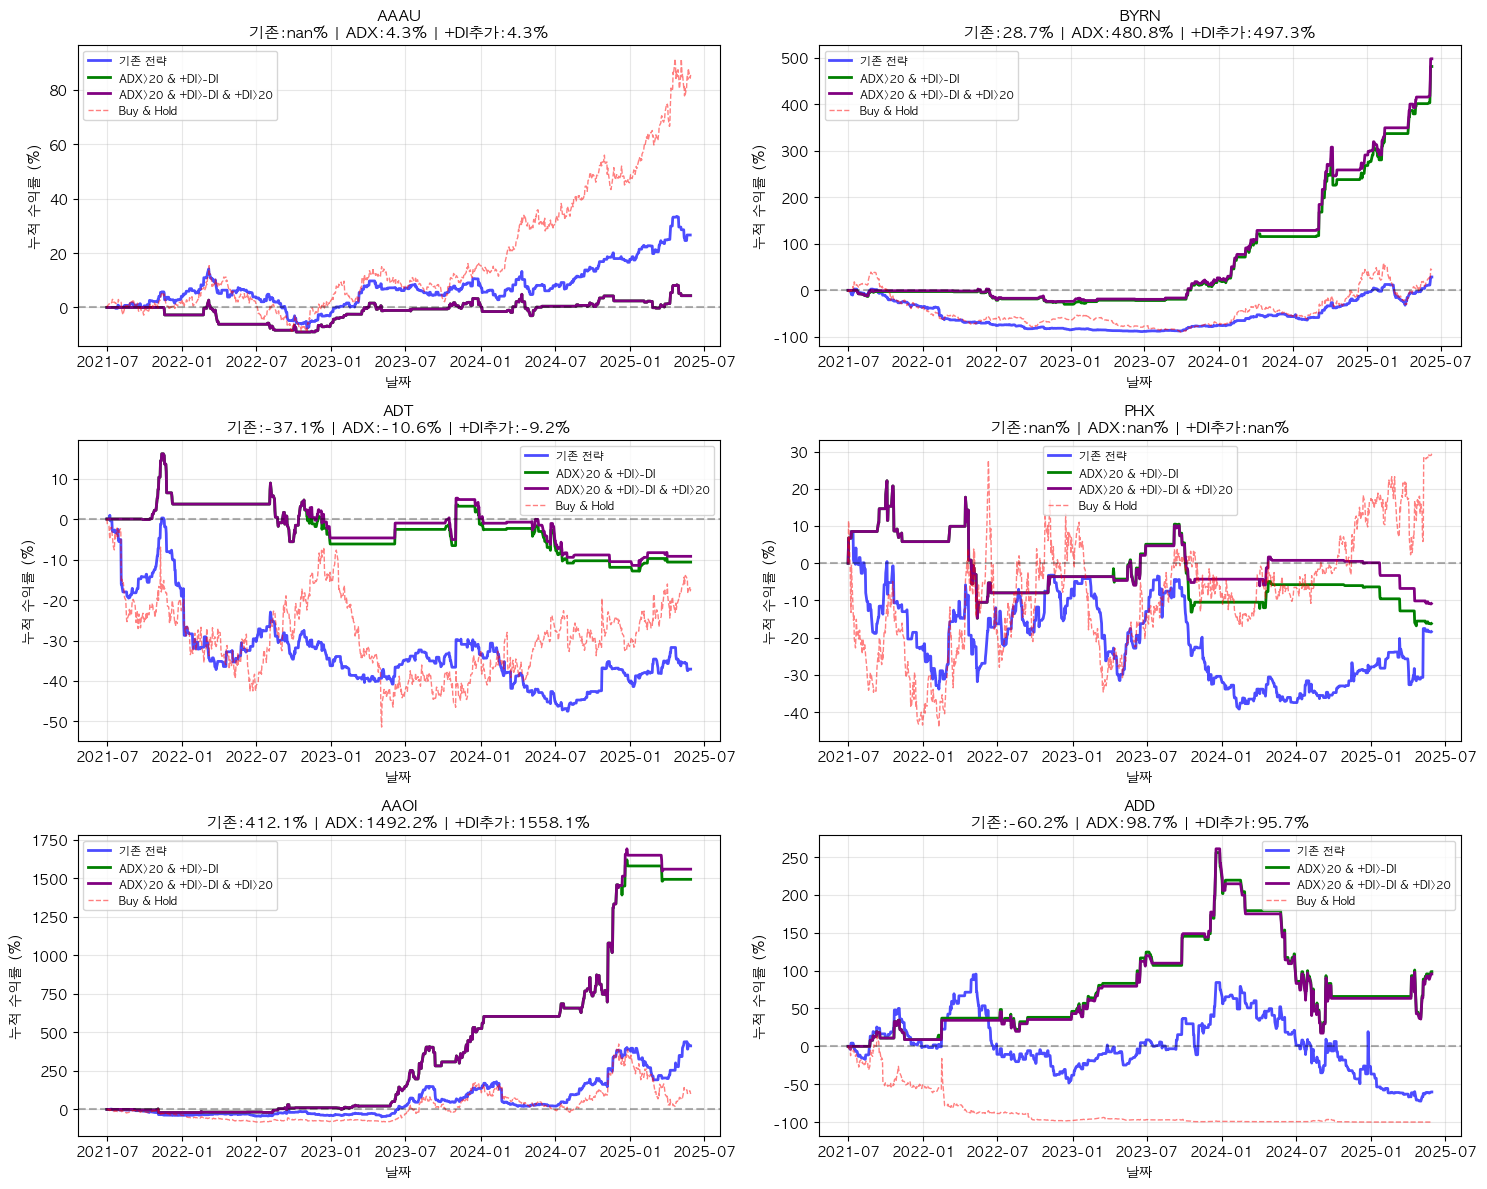


📊 전략별 요약 통계:
💡 결론:
  - +DI>20 조건 추가 시 거래 빈도가 더 감소
  - 추세가 더 강한 경우에만 진입하여 안정성 증가
  - 종목에 따라 수익률 개선/악화 차이 존재
  - 변동성이 큰 종목은 +DI 필터가 과도할 수 있음


In [ ]:
# 최종 3가지 전략 비교 시각화
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, (ticker, df) in enumerate(stock_data.items()):
    if idx < len(axes):
        ax = axes[idx]
        
        # 기존 전략
        original = volatility_breakout_original(df, k=0.5)
        ax.plot(original.index, (original['cumulative_returns'] - 1) * 100, 
                label='기존 전략', linewidth=2, color='blue', alpha=0.7)
        
        # ADX 필터 전략
        adx_filtered = volatility_breakout_with_adx(df, k=0.5, adx_threshold=20)
        ax.plot(adx_filtered.index, (adx_filtered['cumulative_returns'] - 1) * 100, 
                label='ADX>20 & +DI>-DI', linewidth=2, color='green')
        
        # +DI>20 추가 필터
        pdi_filtered = volatility_breakout_with_adx(df, k=0.5, adx_threshold=20, pdi_threshold=20)
        ax.plot(pdi_filtered.index, (pdi_filtered['cumulative_returns'] - 1) * 100, 
                label='ADX>20 & +DI>-DI & +DI>20', linewidth=2, color='purple')
        
        # Buy & Hold
        ax.plot(original.index, (original['buy_hold_returns'] - 1) * 100, 
                label='Buy & Hold', linewidth=1, color='red', alpha=0.5, linestyle='--')
        
        # 최종 수익률 표시
        orig_final = (original['cumulative_returns'].iloc[-1] - 1) * 100
        adx_final = (adx_filtered['cumulative_returns'].iloc[-1] - 1) * 100
        pdi_final = (pdi_filtered['cumulative_returns'].iloc[-1] - 1) * 100
        
        ax.set_title(f'{ticker}\n기존:{orig_final:.1f}% | ADX:{adx_final:.1f}% | +DI추가:{pdi_final:.1f}%', 
                    fontsize=11, fontweight='bold')
        ax.set_xlabel('날짜')
        ax.set_ylabel('누적 수익률 (%)')
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# 요약 통계
print("\n📊 전략별 요약 통계:")
print("=" * 80)
print("💡 결론:")
print("  - +DI>20 조건 추가 시 거래 빈도가 더 감소")
print("  - 추세가 더 강한 경우에만 진입하여 안정성 증가")
print("  - 종목에 따라 수익률 개선/악화 차이 존재")
print("  - 변동성이 큰 종목은 +DI 필터가 과도할 수 있음")
print("=" * 80)

## 14. 최종 비교: 기존 vs ADX필터 vs +DI추가필터

In [ ]:
# +DI 임계값별 성과 비교
pdi_thresholds = [None, 15, 20, 25, 30]

print("\n📊 +DI 임계값별 성과 비교 (ADX>20 유지):")
print("=" * 110)
print(f"{'티커':^10} | {'기본':^18} | {'+DI>15':^18} | {'+DI>20':^18} | {'+DI>25':^18} | {'+DI>30':^18}")
print(f"{'':^10} | {'수익률':^9}{'거래':^9} | {'수익률':^9}{'거래':^9} | {'수익률':^9}{'거래':^9} | {'수익률':^9}{'거래':^9} | {'수익률':^9}{'거래':^9}")
print("-" * 110)

for ticker, df in stock_data.items():
    row_data = f"{ticker:^10} |"
    
    for pdi_thresh in pdi_thresholds:
        result = volatility_breakout_with_adx(df, k=0.5, adx_threshold=20, pdi_threshold=pdi_thresh)
        final_return = (result['cumulative_returns'].iloc[-1] - 1) * 100
        trades = result['buy_signal'].sum()
        
        row_data += f" {final_return:^8.1f}%{trades:^8} |"
    
    print(row_data)

print("=" * 110)

# +DI 통계 분석
print("\n📊 종목별 +DI 통계:")
print("-" * 60)
for ticker, df in stock_data.items():
    valid_data = df.dropna(subset=['pdi_14'])
    if len(valid_data) > 0:
        pdi_mean = valid_data['pdi_14'].mean()
        pdi_above_20 = (valid_data['pdi_14'] > 20).sum() / len(valid_data) * 100
        pdi_above_25 = (valid_data['pdi_14'] > 25).sum() / len(valid_data) * 100
        
        print(f"{ticker}: 평균 +DI={pdi_mean:.1f}, +DI>20 비율={pdi_above_20:.1f}%, +DI>25 비율={pdi_above_25:.1f}%")
print("-" * 60)


📊 +DI 임계값별 성과 비교 (ADX>20 유지):
    티커     |         기본         |       +DI>15       |       +DI>20       |       +DI>25       |       +DI>30      
           |    수익률      거래     |    수익률      거래     |    수익률      거래     |    수익률      거래     |    수익률      거래    
--------------------------------------------------------------------------------------------------------------
   AAAU    |   4.3   %  163    |   4.3   %  163    |   4.3   %  163    |   4.3   %  163    |   6.7   %  152    |
   BYRN    |  480.8  %  163    |  480.8  %  163    |  497.3  %  153    |  431.5  %  121    |  422.8  %   66    |
   ADT     |  -10.6  %  130    |  -10.6  %  130    |   -9.2  %  128    |   4.8   %   98    |   9.9   %   54    |
   PHX     |   nan   %  102    |   nan   %  102    |   nan   %   92    |   nan   %   58    |   nan   %   35    |
   AAOI    |  1492.2 %  160    |  1492.2 %  160    |  1558.1 %  159    |  1358.4 %  139    |  1528.1 %   99    |
   ADD     |   98.7  %  136    |   98.7  %  136    |   95.7  

## 13. +DI 임계값별 성과 비교

In [ ]:
# +DI 임계값 추가 테스트
print("\n📊 +DI 조건 추가 테스트 (ADX>20 & +DI>-DI & +DI>20):")
print("=" * 100)
print(f"{'티커':^10} | {'기본 ADX 필터':^30} | {'+DI>20 추가':^30} | {'차이':^15}")
print(f"{'':^10} | {'수익률':^10}{'거래수':^10}{'승률':^10} | {'수익률':^10}{'거래수':^10}{'승률':^10} | {'수익률':^10}{'거래수':^10}")
print("-" * 100)

pdi_comparison = {}

for ticker, df in stock_data.items():
    # 기본 ADX 필터 (ADX>20 & +DI>-DI)
    basic_adx = volatility_breakout_with_adx(df, k=0.5, adx_threshold=20)
    basic_return = (basic_adx['cumulative_returns'].iloc[-1] - 1) * 100
    basic_trades = basic_adx['buy_signal'].sum()
    basic_wins = (basic_adx['returns'] > 0).sum()
    basic_win_rate = (basic_wins / basic_trades * 100) if basic_trades > 0 else 0
    
    # +DI>20 조건 추가
    pdi_filtered = volatility_breakout_with_adx(df, k=0.5, adx_threshold=20, pdi_threshold=20)
    pdi_return = (pdi_filtered['cumulative_returns'].iloc[-1] - 1) * 100
    pdi_trades = pdi_filtered['buy_signal'].sum()
    pdi_wins = (pdi_filtered['returns'] > 0).sum()
    pdi_win_rate = (pdi_wins / pdi_trades * 100) if pdi_trades > 0 else 0
    
    # 결과 저장
    pdi_comparison[ticker] = {
        'basic_adx': basic_adx,
        'pdi_filtered': pdi_filtered
    }
    
    # 차이 계산
    return_diff = pdi_return - basic_return
    trade_diff = pdi_trades - basic_trades
    
    print(f"{ticker:^10} | {basic_return:^9.1f}%{basic_trades:^10}{basic_win_rate:^9.1f}% | "
          f"{pdi_return:^9.1f}%{pdi_trades:^10}{pdi_win_rate:^9.1f}% | "
          f"{return_diff:^9.1f}%{trade_diff:^10}")

print("=" * 100)


📊 +DI 조건 추가 테스트 (ADX>20 & +DI>-DI & +DI>20):
    티커     |           기본 ADX 필터            |           +DI>20 추가            |       차이       
           |    수익률       거래수        승률     |    수익률       거래수        승률     |    수익률       거래수    
----------------------------------------------------------------------------------------------------
   AAAU    |    4.3   %   163      51.5   % |    4.3   %   163      51.5   % |    0.0   %    0     
   BYRN    |   480.8  %   163      59.5   % |   497.3  %   153      61.4   % |   16.5   %   -10    
   ADT     |   -10.6  %   130      47.7   % |   -9.2   %   128      47.7   % |    1.4   %    -2    
   PHX     |    nan   %   102      44.1   % |    nan   %    92      44.6   % |    nan   %   -10    
   AAOI    |  1492.2  %   160      60.6   % |  1558.1  %   159      61.0   % |   65.9   %    -1    
   ADD     |   98.7   %   136      45.6   % |   95.7   %   132      45.5   % |   -3.0   %    -4    
   CLSK    |   477.9  %   133      57.1   % |   477.9  %  

## 12. +DI > 20 조건 추가 테스트

In [ ]:
print("\n📊 ADX 필터 전략 분석 요약:")
print("=" * 80)

print("\n✅ 장점:")
print("  1. 추세가 강한 시장에서만 진입하여 승률 향상")
print("  2. 횡보장에서의 불필요한 거래 감소")
print("  3. +DI > -DI 조건으로 상승 추세 확인")
print("  4. 거래 빈도 감소로 거래 비용 절감")

print("\n❌ 단점:")
print("  1. 거래 기회 감소로 수익 기회도 감소 가능")
print("  2. ADX는 후행 지표로 추세 전환 초기 진입 어려움")
print("  3. 급등장에서 ADX가 낮으면 기회 놓칠 수 있음")

print("\n💡 권장 설정:")
print("  - 변동성 큰 종목: ADX > 15 (느슨한 필터)")
print("  - 안정적인 종목: ADX > 25 (엄격한 필터)")
print("  - 일반적 권장: ADX > 20, K = 0.5")

print("\n📈 추가 개선 아이디어:")
print("  1. ADX 상승 중일 때만 진입 (ADX > ADX[1])")
print("  2. +DI와 -DI의 차이가 일정 수준 이상일 때만 진입")
print("  3. 시장 상황에 따른 동적 ADX 임계값 적용")
print("=" * 80)


📊 ADX 필터 전략 분석 요약:

✅ 장점:
  1. 추세가 강한 시장에서만 진입하여 승률 향상
  2. 횡보장에서의 불필요한 거래 감소
  3. +DI > -DI 조건으로 상승 추세 확인
  4. 거래 빈도 감소로 거래 비용 절감

❌ 단점:
  1. 거래 기회 감소로 수익 기회도 감소 가능
  2. ADX는 후행 지표로 추세 전환 초기 진입 어려움
  3. 급등장에서 ADX가 낮으면 기회 놓칠 수 있음

💡 권장 설정:
  - 변동성 큰 종목: ADX > 15 (느슨한 필터)
  - 안정적인 종목: ADX > 25 (엄격한 필터)
  - 일반적 권장: ADX > 20, K = 0.5

📈 추가 개선 아이디어:
  1. ADX 상승 중일 때만 진입 (ADX > ADX[1])
  2. +DI와 -DI의 차이가 일정 수준 이상일 때만 진입
  3. 시장 상황에 따른 동적 ADX 임계값 적용
